In [8]:
import utils
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DIR_PATH = "Data"
DIRPATH_EXTRACTED_FEATURES = "extracted_features"

In [9]:
class CustomDataset():
    def __init__(self, brands: list, filenames_features: list, filename_target=utils.FILENAME_RELEVANCE_WINDOW, log_target=False, device=device):
        self.log_target = log_target
        tensor = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_feature), map_location=device) 
                                for filename_feature in filenames_features], dim=1)
                                  for brand in brands], dim=0)
        numpy_array = tensor.detach().numpy()
        features = pd.DataFrame(numpy_array)

        tensor = torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_target), map_location=device) 
                                  for brand in brands], dim=0)
        numpy_array = tensor.detach().numpy()
        self.target = pd.DataFrame(numpy_array)
        if log_target:
              self.target = np.log(self.target)

        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(features, self.target, test_size = 0.1)
    
    def __len__(self):
        return len(self.target)

class CustomRegressor():
    def __init__(self):
        self.regressor = RandomForestRegressor(
            n_estimators=100,
            criterion='squared_error',
            max_depth=None,
            min_samples_leaf=20,
            oob_score=True,
            random_state=0,
            )
        
    def fit(self, Data: CustomDataset):
        self.regressor.fit(Data.features_train, Data.target_train)

    def oob_score(self):
        print(f'Out-of-Bag Score: {self.regressor.oob_score_}')
        
    def score(self, Data: CustomDataset):
        predictions = self.regressor.predict(Data.features_test)
        self.oob_score()
        mse = mean_squared_error(Data.target_test, predictions)
        r2 = r2_score(Data.target_test, predictions)
        print(f'Mean Squared Error: {mse}')
        print(f'R-squared: {r2}')

    def predict_train(self, Data: CustomDataset):
        return self.regressor.predict(Data.features_train)

    def predict_test(self, Data: CustomDataset):
        return self.regressor.predict(Data.features_test)
    
    def predict(self, Data):
        return self.regressor.predict(Data)
        

class CustomClassifier():
    def __init__(self, bins):
        self.bins = bins
        self.classifier = RandomForestClassifier(
            n_estimators=100,
            criterion='gini',
            max_depth=None,
            min_samples_leaf=10,
            oob_score=True,
            random_state=0,
        )
        
    def fit(self, Data: CustomDataset):
        if Data.log_target:
            train_bins = (Data.target_train).map(np.exp)
        else:
            train_bins = Data.target_train
        train_bins = pd.cut(train_bins, bins=self.bins, 
                            labels=[str(self.bins[i]) + '-' + str(self.bins[i + 1]) for i in range(len(self.bins) - 1)])
        self.classifier.fit(Data.features_train, train_bins)

    def oob_score(self):
        print(f'Out-of-Bag Score: {self.classifier.oob_score_}')
        
    def score(self, Data: CustomDataset):
        if Data.log_target:
            test_bins = (Data.target_test).map(np.exp)
        else:
            test_bins = Data.target_train
        test_bins = pd.cut(test_bins, bins=self.bins, 
                            labels=[str(self.bins[i]) + '-' + str(self.bins[i + 1]) for i in range(len(self.bins) - 1)])
        predictions = self.classifier.predict(Data.features_test)
        self.oob_score()
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print("Train Accuracy: %.1f%%" %(train_accuracy * 100))
        print("Test Accuracy: %.1f%%" %(test_accuracy * 100))

    def predict(self, Data: CustomDataset):
        return self.classifier.predict(Data.features_train)

    def predict_test(self, Data: CustomDataset):
        return self.classifier.predict(Data.features_test)

In [10]:
filenames_features = [
    utils.FILENAME_BRAND_OHE,
    utils.FILENAME_PUBLICATION_TIMESTAMP,
    utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
    utils.FILENAME_NUM_WORDS,
    utils.FILENAME_NUM_PARAGRAPH,
    # utils.FILENAME_MAIN_SECTION_OHE,
    # utils.FILENAME_SUBSECTIONS_OHE,
    utils.FILENAME_LDA_TOPICS,
    # utils.FILENAME_IPTC_TOPICS_LEVEL_0,
    # utils.FILENAME_IPTC_TOPICS_LEVEL_1,
]

brands = utils.ALL_BRANDS
brands = ['ad']

In [11]:
Data = CustomDataset(brands, filenames_features, log_target=False)
Data.features_train.shape

/tmp/ipykernel_194018/2800686768.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES,

(89209, 53)

In [12]:
regressor = CustomRegressor()
regressor.fit(Data)
regressor.score(Data)

/home/itsmick_/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Out-of-Bag Score: 0.07209689451271828
Mean Squared Error: 1363.4519731446746
R-squared: 0.08217068701200647


In [13]:
classifier = CustomClassifier(bins=[0,72,1000])

diff mean: 0    22.695132
dtype: float64, diff std: 0    33.739737
dtype: float64
diff mean: 0    20.981791
dtype: float64, diff std: 0    27.904663
dtype: float64


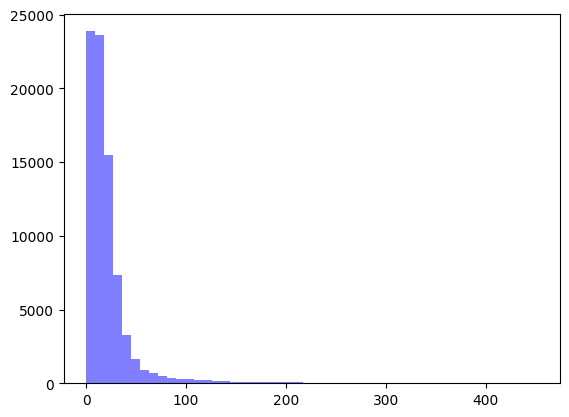

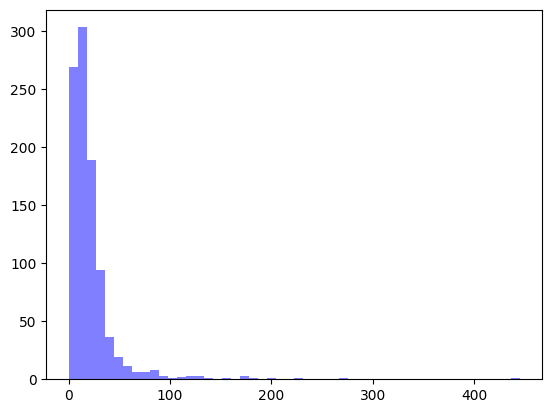

In [14]:
# y_train = dataset[train_dataset.indices][1].cpu()
y_train = pd.DataFrame(Data.target_train)
# y_pred_train = model(dataset[train_dataset.indices][0]).cpu()
y_pred_train = pd.DataFrame(regressor.predict_train(Data))
abs_dif_train = (y_pred_train - y_train).map(np.abs)

# y_test = dataset[test_dataset.indices][1].cpu()
y_test = pd.DataFrame(Data.target_test)
# y_pred_test = model(dataset[test_dataset.indices][0]).cpu()
y_pred_test = pd.DataFrame(regressor.predict_test(Data))
abs_dif_test = (y_pred_test - y_test).map(np.abs)

print(f'diff mean: {abs_dif_train.mean()}, diff std: {abs_dif_train.std()}')
print(f'diff mean: {abs_dif_test.mean()}, diff std: {abs_dif_test.std()}')
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.show()

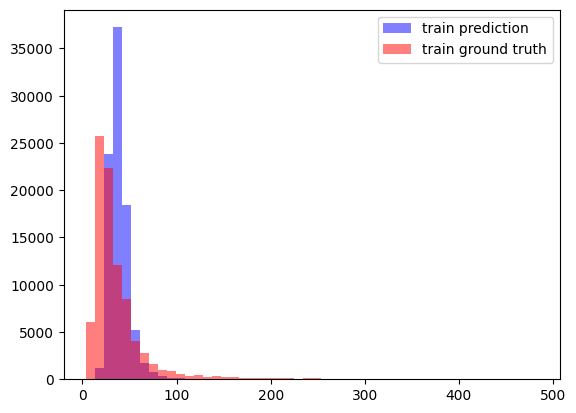

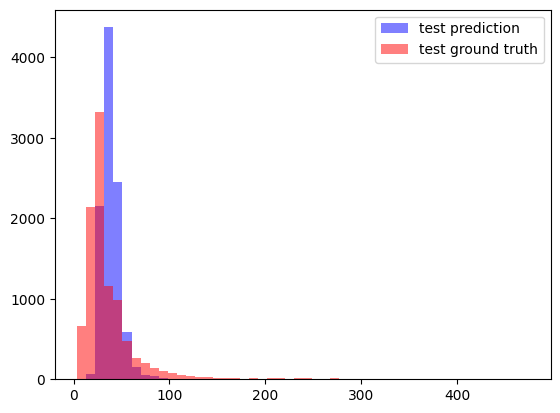

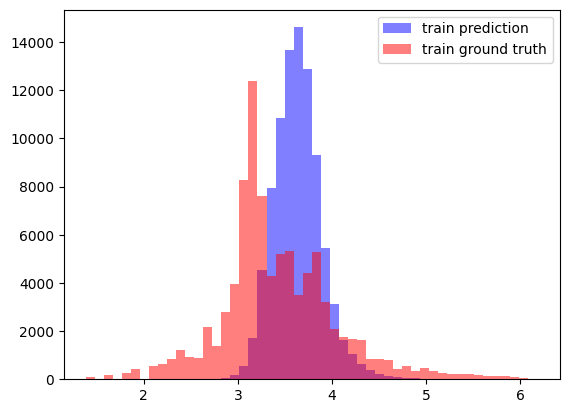

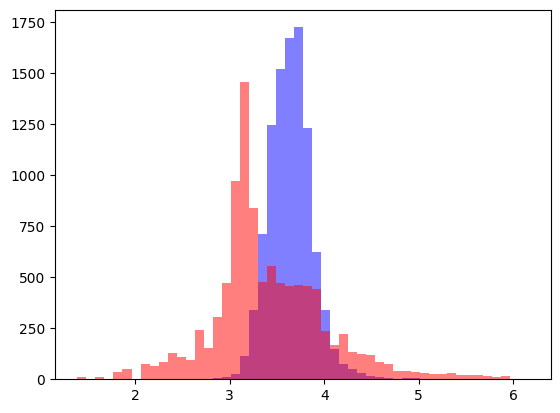

In [15]:
n_bins = 50
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()

if Data.log_target:
    y_pred_train_trans = (y_pred_train).map(np.exp)
    y_train_trans = (y_train).map(np.exp)
    y_pred_test_trans = (y_pred_test).map(np.exp)
    y_test_trans = (y_test).map(np.exp)
else:
    y_pred_train_trans = (y_pred_train).map(np.log)
    y_train_trans = (y_train).map(np.log)
    y_pred_test_trans = (y_pred_test).map(np.log)
    y_test_trans = (y_test).map(np.log)

bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r')
plt.show()